# [ ADP 29회 ML ]
## 분류 & 회귀 - 차원축소, SMOTE, 엄청난 전처리, 변수 생성(Map & Apply)

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 200)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 한글 그래프
import platform

if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        #!wget "https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf"
        #!mv malgun.ttf /usr/share/fonts/truetype/
        #import matplotlib.font_manager as fm 
        #fm._rebuild() 
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [8]:
%config Completer.use_jedi = False

## 데이터 설명  : 아파트 임대 관련
- 데이터 출처 : https://www.data.go.kr/data/15094266/fileData.do 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv
- 데이터 설명 : 대구도시공사_빅데이터_영구임대아파트 입주자 퇴거여부 데이터, 고유번호를 가진 계약자와 특정 아파트에 대해 매년 퇴거여부를 기록한 데이터


## 문제
- 1-1) 계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남겨라.
- 1-2) 결측치 처리
- 1-3) 이상치 처리


- 2-1) 재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 재계약 횟수 이분 변수를 구성하시오.
- 2-2) 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오.


- 3-1) 재계약 횟수 이분변수를 기준으로 세그먼트를 구분하고 각 세그먼트의 특징을 분석하시오.
- 3-2) 재계약횟수 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 재계약횟수 이분변수를 종속변수로 하는 분류 분석을 두가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 
- 3-3) 최종 채택한 모델에서 각각 유의하게 작용하는 변수를 확인 하고 설명하시오.
- 3-4) 해당 데이터 분석결과로 얻을 수 있는 점 제시

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv", encoding="cp949")

print(df.shape, "\n")
print(df.info())
display(df.head())

(86904, 23) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86904 entries, 0 to 86903
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   순번       86904 non-null  int64  
 1   계약구분     86396 non-null  object 
 2   재계약횟수    86904 non-null  int64  
 3   거주개월     86904 non-null  int64  
 4   아파트 이름   86904 non-null  object 
 5   아파트 ID   86904 non-null  int64  
 6   아파트 평점   85679 non-null  float64
 7   호실고유번호   86904 non-null  int64  
 8   층        86904 non-null  int64  
 9   평형대      86904 non-null  int64  
 10  계약자고유번호  86904 non-null  int64  
 11  계약서고유번호  86904 non-null  int64  
 12  입주연도     86904 non-null  int64  
 13  퇴거연도     25762 non-null  float64
 14  거주연도     86904 non-null  int64  
 15  월세(원)    86904 non-null  int64  
 16  보증금(원)   86904 non-null  int64  
 17  대표나이     86904 non-null  int64  
 18  나이       86904 non-null  int64  
 19  성별       86904 non-null  object 
 20  결혼여부     86904 non-null  object 
 21

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2008,47100,3646000,46,33,남,미혼,3,미퇴거
1,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2009,56500,4375000,46,34,남,미혼,3,미퇴거
2,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2010,56500,4375000,46,35,남,미혼,3,미퇴거
3,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2011,69900,5408000,46,36,남,미혼,3,미퇴거
4,1,유효,10,222,강남아파트,5,7.0,14520,1,12,15468,15865,2003,NaN,2012,69900,5408000,46,37,남,미혼,3,미퇴거


## 1-1 계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남겨라.

In [3]:
df[["계약자고유번호", "거주연도"]]

,계약자고유번호,거주연도
0,15468,2008
1,15468,2009
2,15468,2010
3,15468,2011
4,15468,2012
...,...,...
86899,6264,2017
86900,6264,2018
86901,85274,2018
86902,85274,2019


### 계약자 고유번호 거주연도 기준으로 정렬 & 계약자 고유번호가 중복인 데이터를 제거

In [4]:
result = df.sort_values(['계약자고유번호','거주연도']).drop_duplicates('계약자고유번호', keep='last').reset_index(drop=True)
print(result.shape, "\n")
display(result.head(3))

(10348, 23) 



,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,12673,해지,4,88,지산5단지아파트,3,8.0,85369,6,12,1,1,2005,2012.0,2012,77300,5302000,44,35,남,기혼,2,퇴거
1,12683,해지,7,174,지산5단지아파트,3,8.0,85421,6,15,6,6,2001,2016.0,2016,48600,2144000,32,27,남,미혼,1,퇴거
2,12702,유효,10,237,지산5단지아파트,3,8.0,85576,7,15,14,14,2001,NaN,2020,81600,5598000,67,66,남,미혼,1,미퇴거


## 1-2) 결측치 처리

In [5]:
result.isnull().sum()

순번            0
계약구분         61
재계약횟수         0
거주개월          0
아파트 이름        0
아파트 ID        0
아파트 평점      141
호실고유번호        0
층             0
평형대           0
계약자고유번호       0
계약서고유번호       0
입주연도          0
퇴거연도       6257
거주연도          0
월세(원)         0
보증금(원)        0
대표나이          0
나이            0
성별            0
결혼여부          0
거주자 수         0
퇴거여부          0
dtype: int64

### 기존 데이터의 결측치는 계약구분, 아파트 평점, 퇴거연도 3가지 컬럼에서 존재

In [6]:
display(result.head())
display(result.tail())

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
0,12673,해지,4,88,지산5단지아파트,3,8.0,85369,6,12,1,1,2005,2012.0,2012,77300,5302000,44,35,남,기혼,2,퇴거
1,12683,해지,7,174,지산5단지아파트,3,8.0,85421,6,15,6,6,2001,2016.0,2016,48600,2144000,32,27,남,미혼,1,퇴거
2,12702,유효,10,237,지산5단지아파트,3,8.0,85576,7,15,14,14,2001,NaN,2020,81600,5598000,67,66,남,미혼,1,미퇴거
3,12789,유효,10,227,지산5단지아파트,3,8.0,86179,10,19,27,27,2002,NaN,2020,66600,3116000,61,60,남,기혼,3,미퇴거
4,12796,유효,10,222,지산5단지아파트,3,8.0,86224,10,15,40,40,2003,NaN,2020,129240,8865600,58,57,여,미혼,2,미퇴거


,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
10343,29,유효,1,9,강남아파트,5,7.0,15103,3,12,86866,16959,2020,NaN,2020,42800,2078000,69,68,남,미혼,1,미퇴거
10344,4,유효,1,8,강남아파트,5,7.0,14546,1,12,86867,16960,2020,NaN,2020,38000,2078000,66,65,남,미혼,1,미퇴거
10345,8511,유효,6,133,용지아파트,2,7.0,56917,10,12,86868,44775,2010,NaN,2020,43600,2052000,55,54,남,미혼,1,미퇴거
10346,8119,유효,10,222,용지아파트,2,7.0,54063,3,12,86879,36875,2003,NaN,2020,42400,2052000,42,41,여,미혼,1,미퇴거
10347,1506,유효,10,234,비둘기아파트,1,5.0,7782,5,12,86892,62861,2002,NaN,2020,42400,2062000,44,43,남,미혼,2,미퇴거


In [9]:
result[["아파트 이름", "아파트 평점"]].drop_duplicates()

,아파트 이름,아파트 평점
0,지산5단지아파트,8.0
26,지산5단지아파트,NaN
214,용지아파트,7.0
606,비둘기아파트,5.0
1403,까치아파트,10.0
1405,까치아파트,NaN
1602,강남아파트,7.0
1668,강남아파트,NaN
1730,용지아파트,NaN
5403,비둘기아파트,NaN


### 계약구분의 경우 퇴거여부와 1대1 매핑이 되고, 아파트 평점의 경우에도 아파트 이름에 따라 1대1 매핑됨을 확인
- 계약구분 : 해지 -> 퇴거여부 : 퇴거
- 계약구분 : 유효 -> 퇴거여부 : 미퇴거


- 지산5단지아파트 : 8
- 용지아파트 : 7
- 비둘기아파트 : 5
- 까치아파트 : 10
- 강남아파트 : 7

### 퇴거연도가 NaN값 = 퇴거여부가 미퇴거 상태
- '퇴거 연도의 경우 현재 "미퇴거" 상태라면 애초에 존재하지 않는 값(NaN)이기 때문에 컬럼 자체를 제거한다.
    - 퇴거연도의 칼럼 결측치가 6000개가 넘기도 함

In [10]:
# 위에 따라 결측치를 처리

pre_df = result.copy()
dic = {'퇴거':'해지', '미퇴거':'유효'}
pre_df['계약구분'] = pre_df['퇴거여부'].map(dic)

dic_apt = {'강남아파트': 7.0, '까치아파트': 10.0, '비둘기아파트': 5.0, 
           '용지아파트': 7.0, '지산5단지아파트': 8.0}
pre_df['아파트 평점'] = pre_df['아파트 이름'].map(dic_apt)

pre_df = pre_df.drop(columns =['퇴거연도'])
# display(result.isnull().sum().where(lambda x : x != 0)\
#         .dropna().to_frame().rename(columns ={0:'결측치 숫자'}).astype('int'))

,결측치 숫자
계약구분,61
아파트 평점,141
퇴거연도,6257


## 1-3) 이상치 처리

In [11]:
pre_df.describe()

,순번,재계약횟수,거주개월,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,거주연도,월세(원),보증금(원),대표나이,나이,거주자 수
count,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,1.034800e+04,10348.000000,10348.000000,10348.000000
mean,6422.183610,5.873695,137.773579,1.809432,6.363645,42980.835330,7.861229,13.220236,48508.618187,46320.571415,2007.092482,2017.752319,63941.468883,3.807054e+06,65.874758,62.627078,1.688152
std,3729.145894,3.215195,77.544927,0.866580,1.284676,25016.449224,4.284426,2.338369,26845.947221,26014.408368,6.224812,3.639131,40259.713978,3.087981e+06,13.787216,14.179781,0.985380
min,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,12.000000,1.000000,1.000000,1994.000000,2008.000000,31300.000000,1.520000e+06,21.000000,20.000000,1.000000
25%,3175.250000,3.000000,71.000000,1.000000,5.000000,21277.750000,4.000000,12.000000,25058.750000,23252.000000,2002.000000,2016.000000,42300.000000,2.052000e+06,57.000000,54.000000,1.000000
50%,6458.500000,6.000000,137.000000,2.000000,7.000000,42946.000000,8.000000,12.000000,48593.500000,48036.500000,2004.000000,2020.000000,44700.000000,2.304000e+06,65.000000,63.000000,1.000000
75%,9637.500000,9.000000,222.000000,2.000000,7.000000,64589.500000,12.000000,12.000000,74050.250000,69061.250000,2012.000000,2020.000000,66700.000000,3.943000e+06,75.000000,73.000000,2.000000
max,12883.000000,12.000000,323.000000,5.000000,10.000000,86891.000000,15.000000,19.000000,86892.000000,86904.000000,2020.000000,2020.000000,311080.000000,2.078400e+07,121.000000,120.000000,10.000000


- 시험장에서 직접 한 풀이) 대표나이, 나이에서 max 가 121, 120으로 이상값으로 추정돼서 해당 데이터 확인하고 삭제했음
- 본 풀이에서는 연령대별로 계산해서 변경

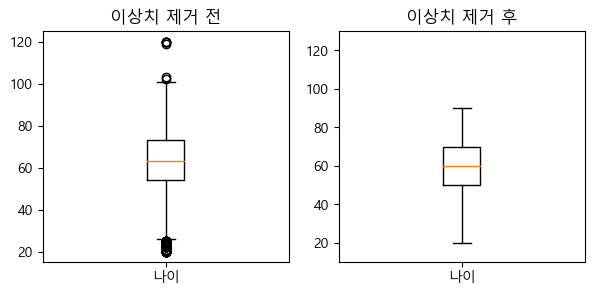

In [12]:
# 연령대별로 계산, lambda 함수 이용해서 90(대)로 변경
pre_df['나이_이상치_제거'] = (pre_df['나이'] //10 *10).map(lambda x : 90 if x >= 90 else x)

fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].boxplot(pre_df['나이'])
ax[1].boxplot(pre_df['나이_이상치_제거'])

ax[0].set_title('이상치 제거 전')
ax[1].set_title('이상치 제거 후')

ax[1].set_ylim(10,130)

ax[0].set_xticks([1], ['나이'])
ax[1].set_xticks([1], ['나이'])
plt.show()

<AxesSubplot:>

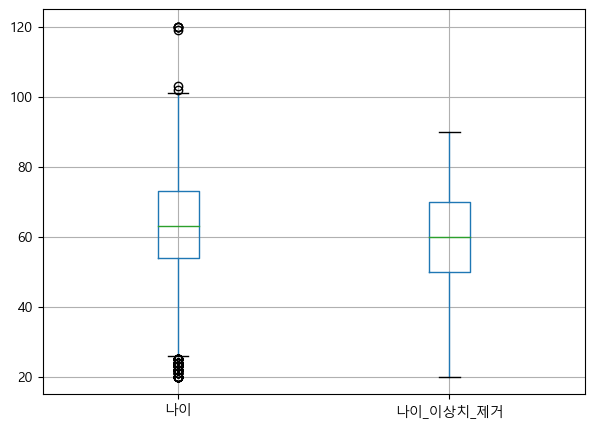

In [29]:
# # 코드 간단 ver
# # 연령대별로 계산, lambda 함수 이용해서 90(대)로 변경
# pre_df['나이_이상치_제거'] = (pre_df['나이'] //10 *10).map(lambda x : 90 if x >= 90 else x)

# plt.figure(figsize=(7,5))
# pre_df[['나이', '나이_이상치_제거']].boxplot()

In [13]:
# 원 데이터인 나이 칼럼 제거

pre_df = pre_df.drop("나이", axis=1)
pre_df.columns

Index(['순번', '계약구분', '재계약횟수', '거주개월', '아파트 이름', '아파트 ID', '아파트 평점', '호실고유번호',
       '층', '평형대', '계약자고유번호', '계약서고유번호', '입주연도', '거주연도', '월세(원)', '보증금(원)',
       '대표나이', '성별', '결혼여부', '거주자 수', '퇴거여부', '나이_이상치_제거'],
      dtype='object')

## 2-1) 재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 재계약 횟수 이분 변수를 구성하시오.

In [14]:
pre_df["재계약횟수"].median()

6.0

In [15]:
# pre_df["재계약횟수"].median()

def cat(x) :
    cat = ''
    if x < 6.0 :
        cat = "낮음"
    elif x >= 6.0 :
        cat = "높음"
    return cat

pre_df["재계약횟수_이분변수"] = df["재계약횟수"].apply(cat)

display(pre_df.head())
display(pre_df.tail())

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,거주연도,월세(원),보증금(원),대표나이,성별,결혼여부,거주자 수,퇴거여부,나이_이상치_제거,재계약횟수_이분변수
0,12673,해지,4,88,지산5단지아파트,3,8.0,85369,6,12,1,1,2005,2012,77300,5302000,44,남,기혼,2,퇴거,30,높음
1,12683,해지,7,174,지산5단지아파트,3,8.0,85421,6,15,6,6,2001,2016,48600,2144000,32,남,미혼,1,퇴거,20,높음
2,12702,유효,10,237,지산5단지아파트,3,8.0,85576,7,15,14,14,2001,2020,81600,5598000,67,남,미혼,1,미퇴거,60,높음
3,12789,유효,10,227,지산5단지아파트,3,8.0,86179,10,19,27,27,2002,2020,66600,3116000,61,남,기혼,3,미퇴거,60,높음
4,12796,유효,10,222,지산5단지아파트,3,8.0,86224,10,15,40,40,2003,2020,129240,8865600,58,여,미혼,2,미퇴거,50,높음


,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,거주연도,월세(원),보증금(원),대표나이,성별,결혼여부,거주자 수,퇴거여부,나이_이상치_제거,재계약횟수_이분변수
10343,29,유효,1,9,강남아파트,5,7.0,15103,3,12,86866,16959,2020,2020,42800,2078000,69,남,미혼,1,미퇴거,60,높음
10344,4,유효,1,8,강남아파트,5,7.0,14546,1,12,86867,16960,2020,2020,38000,2078000,66,남,미혼,1,미퇴거,60,높음
10345,8511,유효,6,133,용지아파트,2,7.0,56917,10,12,86868,44775,2010,2020,43600,2052000,55,남,미혼,1,미퇴거,50,높음
10346,8119,유효,10,222,용지아파트,2,7.0,54063,3,12,86879,36875,2003,2020,42400,2052000,42,여,미혼,1,미퇴거,40,낮음
10347,1506,유효,10,234,비둘기아파트,1,5.0,7782,5,12,86892,62861,2002,2020,42400,2062000,44,남,미혼,2,미퇴거,40,낮음


In [35]:
# # lambda & map 쉬운 버전

# #중앙값은 6이다. 이를 기준으로 이분변수를 나누고 새로운 컬럼을 만든다.
# med = pre_df['재계약횟수'].median()

# pre_df['이분변수'] = pre_df['재계약횟수'].map(lambda x : '높음' if x >= med else '낮음')
# display(pre_df['이분변수'].value_counts().to_frame())

,이분변수
높음,5388
낮음,4960


## 2-2) 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오.

- 주성분으로 특징 통합 등의 차원축소를 수행하면 데이터의 특성들이 혼합되어 결과 해석이 어려워 질 수 있다. 본 데이터는 각 변수들이 명확한 의미를 가지고 있고, 모델의 해석이 중요한 경우라고 생각한다. 차원축소를 하게 되면 기존 변수들의 해석 가능성이 저하될 문제가 발생할 수 있어 신중하게 고려해야한다. 따라서 본 분석에서는 차원 축소가 필요하지 않다고 판단했다.

## 3-1) 재계약 횟수 이분변수를 기준으로 세그먼트를 구분하고 각 세그먼트의 특징을 분석하시오.

- 시험장에서 직접 한 풀이) 이분변수별 groupby, mean해서 높은 집단과 낮은 집단의 각 변수별 평균 하나하나 비교하고 특징 서술
- 본 풀이에서는 그래프 시각화 위주 !

### 데이터 전처리 : 불필요 칼럼 제거
- 순번, 아파트 이름, 호실 고유번호, 계약자 고유번호, 계약서 고유번호는 데이터 구분을 위한 특정 PK이기 때문에 제거
- 대표나이의 경우 2020년 기준의 나이이기 때문에 제거

- 명목형 변수 중 아파트이름은 아파트ID와 같은 의미를 가진 변수라 삭제한다.
- 호실고유번호, 순번, 계약자고유번호, 계약서고유번호는 인덱스 값이므로 삭제한다.
- 거주연도가 가장 최근인 데이터로 남겼으므로, 거주연도는 삭제한다.

In [16]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10348 entries, 0 to 10347
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   순번          10348 non-null  int64  
 1   계약구분        10348 non-null  object 
 2   재계약횟수       10348 non-null  int64  
 3   거주개월        10348 non-null  int64  
 4   아파트 이름      10348 non-null  object 
 5   아파트 ID      10348 non-null  int64  
 6   아파트 평점      10348 non-null  float64
 7   호실고유번호      10348 non-null  int64  
 8   층           10348 non-null  int64  
 9   평형대         10348 non-null  int64  
 10  계약자고유번호     10348 non-null  int64  
 11  계약서고유번호     10348 non-null  int64  
 12  입주연도        10348 non-null  int64  
 13  거주연도        10348 non-null  int64  
 14  월세(원)       10348 non-null  int64  
 15  보증금(원)      10348 non-null  int64  
 16  대표나이        10348 non-null  int64  
 17  성별          10348 non-null  object 
 18  결혼여부        10348 non-null  object 
 19  거주자 수       10348 non-nul

In [17]:
pre_df = pre_df.drop(["순번", "아파트 이름", "호실고유번호", "계약자고유번호", "계약서고유번호"], axis=1)
pre_df

,계약구분,재계약횟수,거주개월,아파트 ID,아파트 평점,층,평형대,입주연도,거주연도,월세(원),보증금(원),대표나이,성별,결혼여부,거주자 수,퇴거여부,나이_이상치_제거,재계약횟수_이분변수
0,해지,4,88,3,8.0,6,12,2005,2012,77300,5302000,44,남,기혼,2,퇴거,30,높음
1,해지,7,174,3,8.0,6,15,2001,2016,48600,2144000,32,남,미혼,1,퇴거,20,높음
2,유효,10,237,3,8.0,7,15,2001,2020,81600,5598000,67,남,미혼,1,미퇴거,60,높음
3,유효,10,227,3,8.0,10,19,2002,2020,66600,3116000,61,남,기혼,3,미퇴거,60,높음
4,유효,10,222,3,8.0,10,15,2003,2020,129240,8865600,58,여,미혼,2,미퇴거,50,높음
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,유효,1,9,5,7.0,3,12,2020,2020,42800,2078000,69,남,미혼,1,미퇴거,60,높음
10344,유효,1,8,5,7.0,1,12,2020,2020,38000,2078000,66,남,미혼,1,미퇴거,60,높음
10345,유효,6,133,2,7.0,10,12,2010,2020,43600,2052000,55,남,미혼,1,미퇴거,50,높음
10346,유효,10,222,2,7.0,3,12,2003,2020,42400,2052000,42,여,미혼,1,미퇴거,40,낮음


### describe로 간단 풀이

In [18]:
pre_df.groupby("재계약횟수_이분변수").mean()

,재계약횟수,거주개월,아파트 ID,아파트 평점,층,평형대,입주연도,거주연도,월세(원),보증금(원),대표나이,거주자 수,나이_이상치_제거
재계약횟수_이분변수,,,,,,,,,,,,,
낮음,5.763198,135.121041,1.766968,6.299774,7.967195,13.291101,2007.400075,2017.824661,63628.442685,3.803508e+06,65.418175,1.708522,57.767722
높음,5.911772,138.687630,1.824064,6.385655,7.824714,13.195816,2006.986486,2017.727391,64049.336019,3.808276e+06,66.032095,1.681133,58.230249


재계약 횟수 이분변수의 값을 기준으로 변수들의 평균을 비교한 결과이다.
- 재계약횟수 이분변수가 높은 집단은, 낮은 집단보다 거주개월이 높은 편이다. 또한 월세와 연령대 또한 높은 편으로 보인다.



(1. 재계약횟수 '낮음' 집단 / 2. 재계약횟수 '높음' 집단 나눠서 구체적으로 변수 각각 설명하는 방법도 고려할 수 있을 듯)

In [19]:
pre_df.describe(include="O")

,계약구분,성별,결혼여부,퇴거여부,재계약횟수_이분변수
count,10348,10348,10348,10348,10348
unique,2,2,2,2,2
top,유효,여,미혼,미퇴거,높음
freq,6257,5898,8968,6257,7696


### 재계약횟수 이분변수에 따른 범주형 변수 시각화

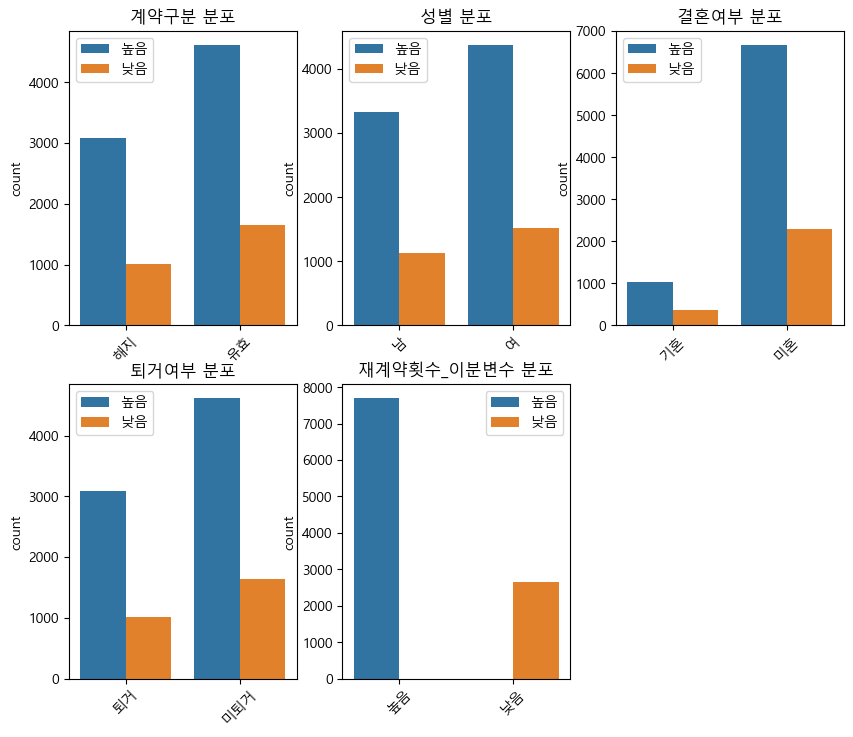

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_columns = pre_df.select_dtypes(include=["object"]).columns

plt.figure(figsize=(10, 13))
# plt.tight_layout(pad=5.0)  # 서브플롯 간 간격 조절

for idx, col in enumerate(categorical_columns, start=1):
    plt.subplot(3, 3, idx)
    ax = sns.countplot(data=pre_df, x=col, hue="재계약횟수_이분변수")
    plt.title(f"{col} 분포")
    plt.xticks(rotation=45)
    plt.xlabel('')
    
    # 범례 수정
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[:], labels=["높음", "낮음"])

plt.show()

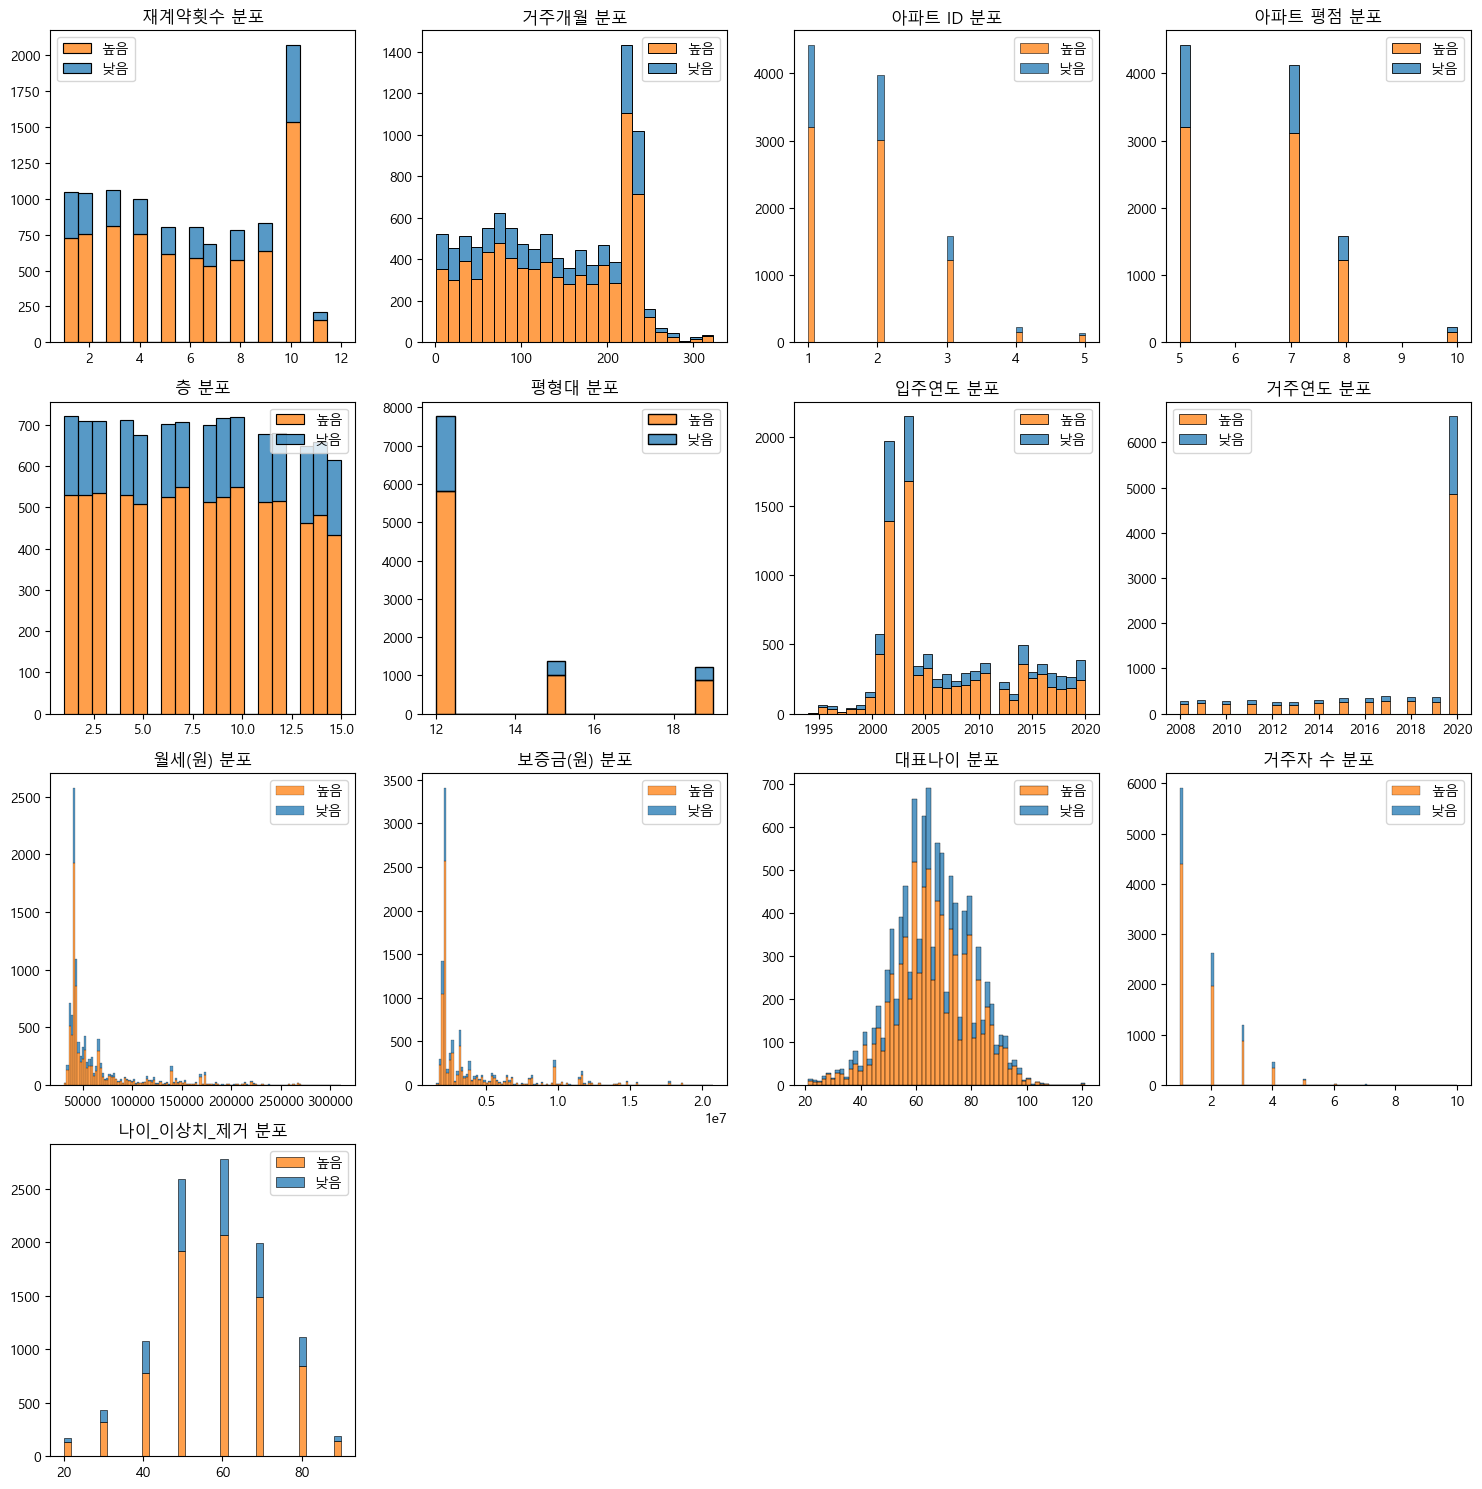

In [129]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# numerical_columns = pre_df.select_dtypes(include=["int64", "float64"]).columns

# plt.figure(figsize=(15, 15))  # 전체 그림 크기 조정

# for idx, col in enumerate(numerical_columns, start=1):
#     plt.subplot(4, 4, idx)
#     sns.histplot(data=pre_df, x=col, hue="재계약횟수_이분변수", multiple="stack")
#     plt.title(f"{col} 분포")
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.legend(["높음", "낮음"])

# plt.tight_layout()  # 서브플롯 간 간격 조절
# plt.show()

## 3-2) 재계약횟수 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 재계약횟수 이분변수를 종속변수로 하는 분류 분석을 두가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 

### 데이터 전처리 : 인코딩

In [21]:
from sklearn.preprocessing import LabelEncoder

for col in pre_df.select_dtypes(include=object):
    le = LabelEncoder()
    
    pre_df[col] = le.fit_transform(pre_df[col])

### 랜덤포레스트 & lgbm 라이브러리

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import time

In [30]:
model_df = pre_df.copy()

X = model_df.drop(columns =['재계약횟수','재계약횟수_이분변수', '거주연도','입주연도'])

reg_y = model_df['재계약횟수']
cls_y = model_df['재계약횟수_이분변수']

### 재계약횟수 변수를 종속변수로 하는 '회귀분석'

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, reg_y, test_size = 0.3, random_state=42)
X_train.shape, X_test.shape

((7243, 14), (3105, 14))

#### 랜덤포레스트 회귀

In [32]:
reg_rf = RandomForestRegressor(random_state = 3)

# reg_rf 
start = time.time()
reg_rf.fit(X_train, y_train)

print('학습시간: ', time.time()-start)

rf_pred = reg_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
print("랜포 mse : ", rf_mse)

학습시간:  2.2578866481781006
랜포 mse :  0.5055334970906774


#### lgbm 회귀

In [33]:
reg_lgbm = LGBMRegressor(random_state = 3)

# reg_lgbm
start = time.time()
reg_lgbm.fit(X_train, y_train)
print('학습시간: ', time.time()-start)

lgbm_pred = reg_lgbm.predict(X_test)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
print("lgbm mse : ", lgbm_mse)

학습시간:  0.18944358825683594
lgbm mse :  0.39771015044244934


### 재계약횟수 이분변수를 종속변수로 하는 분류 분석

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, cls_y, test_size = 0.3, random_state=42)
X_train.shape, X_test.shape

((7243, 14), (3105, 14))

#### 랜덤포레스트 분류

In [35]:
cls_rf = RandomForestClassifier(random_state = 3)

start = time.time()
cls_rf.fit(X_train,y_train)

print('학습시간: ', time.time()-start)

rf_pred = cls_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("랜포 acc : ", rf_acc)

학습시간:  1.0143554210662842
랜포 acc :  0.7278582930756844


In [36]:
cls_lgbm = LGBMClassifier(random_state = 3)

start = time.time()
cls_lgbm.fit(X_train,y_train)

print('학습시간: ', time.time()-start)

lgbm_pred = cls_lgbm.predict(X_test)
lgbm_acc = accuracy_score(y_test, lgbm_pred)
        
print("lgbm acc : ", lgbm_acc)

학습시간:  0.18541717529296875
lgbm acc :  0.7426731078904992


- 모델의 변수중요도를 확인하기 위해 트리류 모델들로 비교한다. 
- 회귀모델과 분류모델 각각 랜덤포레스트와 lgbm 모델에 대해 학습하고 결과를 비교한다.
- 분류의 경우 정확도로 모델을 평가하고 회귀모델의 경우 평균제곱오차를 통해 모델을 비교한다. 

- 정확도는 숫자가 클수록 좋은 모델이고, mse는 그 값이 작을 수록 모델 오차가 작다고 판단 할 수 있다. 
- 70%의 데이터로 학습하고, 30%의 모델로 평가했을 때 분류와 회귀 모두 lgbm 모델이 더 좋은 성능을 보였다.
- 따라서 최종 모델은 각각 lgbm 회귀, lgbm 분류로 선택한다.

## 3-3) 최종 채택한 모델에서 각각 유의하게 작용하는 변수를 확인 하고 설명하시오.
- X_train 칼럼명은 모두 동일

In [58]:
# # 변수 중요도 출력
# fi = cls_lgbm.feature_importances_
# fn = X_train.columns

# # 변수 중요도를 오름차순으로 정렬한 인덱스
# sorted_idx = np.argsort(fi)

# plt.figure(figsize=(5, 5))

# # 오름차순으로 정렬한 변수 중요도와 변수 이름으로 막대 그래프 생성
# plt.barh(fn[sorted_idx], fi[sorted_idx])
# plt.xlabel('Variable Importance')
# plt.title('lgbm 분류 모델 변수 중요도')
# plt.show()

In [59]:
# # 변수 중요도 출력
# fi = reg_lgbm.feature_importances_
# fn = X_train.columns

# # 변수 중요도를 오름차순으로 정렬한 인덱스
# sorted_idx = np.argsort(fi)

# plt.figure(figsize=(5, 5))

# # 오름차순으로 정렬한 변수 중요도와 변수 이름으로 막대 그래프 생성
# plt.barh(fn[sorted_idx], fi[sorted_idx])
# plt.xlabel('Variable Importance')
# plt.title('lgbm 회귀 모델 변수 중요도')
# plt.show()

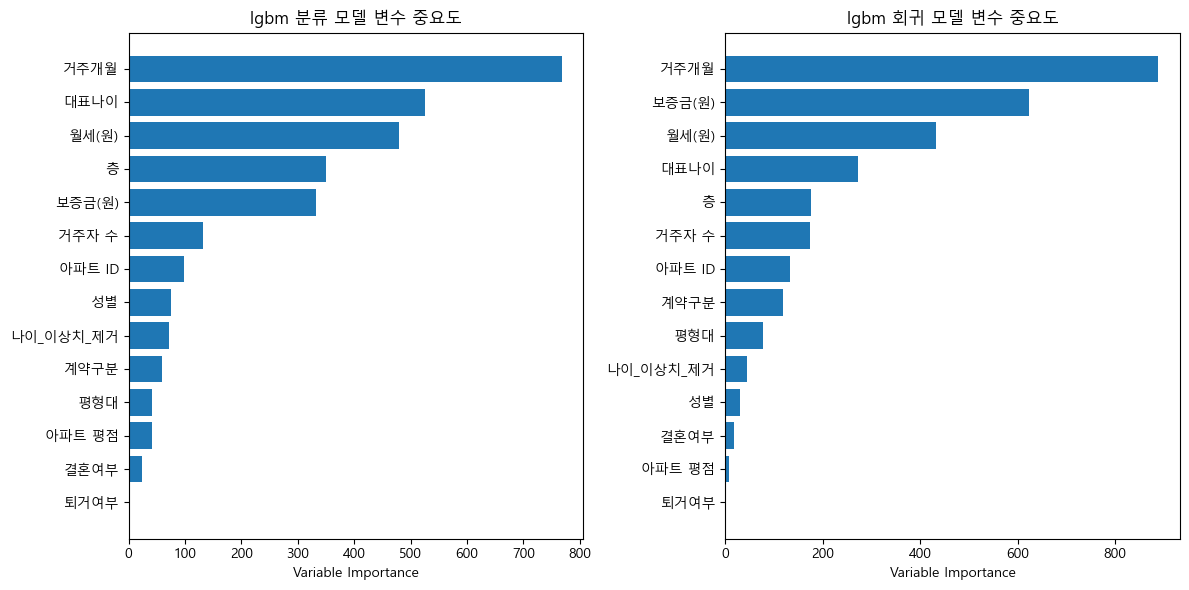

In [57]:
# 변수 중요도 출력 함수
def plot_variable_importance(ax, fi, fn, title):
    # 변수 중요도를 오름차순으로 정렬한 인덱스
    sorted_idx = np.argsort(fi)
    
    ax.barh(fn[sorted_idx], fi[sorted_idx])
    ax.set_xlabel('Variable Importance')
    ax.set_title(title)

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 그래프 (분류 모델 변수 중요도)
plot_variable_importance(axes[0], 
                         cls_lgbm.feature_importances_, 
                         X_train.columns, 
                         'lgbm 분류 모델 변수 중요도')

# 두 번째 그래프 (회귀 모델 변수 중요도)
plot_variable_importance(axes[1], 
                         reg_lgbm.feature_importances_, 
                         X_train.columns, 
                         'lgbm 회귀 모델 변수 중요도')

# 레이아웃 조정
plt.tight_layout()
plt.show()

lgbm 분류모델의 경우
- 거주개월이 가장 변수 중요도가 높았다. 그리고 대표나이, 월세, 층, 보증금 순으로 중요도가 높았다.

lgbm 회귀모델의 경우
- 분류모델과 마찬가지로 거주개월이 가장 변수 중요도가 높았다.
- 보증금이 두번째로 높았으며, 월세와 대표나이, 층 순으로 중요도가 높았다.

## 3-4) 해당 데이터 분석결과로 얻을 수 있는 점 제시

1. 예측 모델 변수 중요도가 가장 높은 거주 개월 
- 거주개월이 재계약 횟수 예측에 있어 가장 중요한 변수로 확인됐는데, 이는 장기 거주하는 세입자가 재계약을 더 자주하는 경향이 있다고 해석할 수 있다.
- 거주기간이 길어질수록 해당 아파트나 주택에 대한 만족도나 부착감이 높아져 재계약의 가능성이 높아지는 것으로 볼 수 있다.

2. 월세가 모델에서 두 번째와 세 번째로 중요한 변수로 나타남
- 월세가 모델에서 두 번째와 세 번째로 중요한 변수로 나타난 것은, 재계약 의사와 금액에 대한 세입자의 부담감 사이에 상관관계가 있을 수 있음을 시사한다. 
- 높은 보증금 또는 월세는 재계약 의사에 부담을 줄 수 있으며, 따라서 부동산 시장의 동향 및 세입자의 수요를 고려하여 적정한 금액을 설정하는 것이 중요할 것으로 보인다.

위의 결과는 부동산 관련 업체나 정부 정책 담당자들이 재계약을 유도하기 위한 전략을 세우거나, 장기 거주 세입자들의 요구사항을 파악하여 만족도를 높이기 위한 방안을 모색할 때 참고할 수 있는 통찰력을 제공할 것으로 보인다.


---

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018 데이터를 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv
- 데이터 설명 : 

A 야구구단의 시합 결과중 일부를 나타낸다.    
각 행은 하나의 경기를 의미(game_id)하며 9회차(= 9이닝) 동안 1번타자, 2번타자의 출루 정보를 의미한다.     
각 컬럼에 대한 설명은 아래 이미지와 같으며, value값의 index는 이미지의 '수치 의미' 열을 통해 확인 할 수 있다.

<img src="https://github.com/Datamanim/datarepo/blob/main/adp/29/p1_img.png?raw=true" width="500" height="600">

## 문제
- 4-1) 각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에 맞는 공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다. 이를 위한 전처리를 수행하라. (단, 첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터는 제외한다.)  
```
조건1 : 득점여부를 범주형 종속변수로 한다. (1점이상 득점 :1, 무득점 :0)
조건2 : 각 회차 2번 타자의 데이터는 원핫 인코딩한다.
조건3 : 학습에 적절하지 않은 데이터는 제외한다.
```
- 4-2) 4-1 데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정을 하라.
- 4-3) SMOTE (random_state =0 지정)를 적용하여 data imbalance를 해결하라.
- 4-4) 4-3 구성 데이터에 Logistic Regression을 적용하고 결과를 분석하라.
- 4-5) 4-3 구성 데이터에 XGB 적용하고 결과를 분석하라. 


참고 : 로지스틱이 2번 나오진 않았던 것 같고 무슨 확률 검정, 빈도표 제시하라는 문제가 있었던 것 같은데 가장 헬인 기출이었음 .. 시험장에서도 멘붕 그 자체

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv')
print(df.shape)
display(df.head())

(200, 28)


,game_id,a1_1,a1_2,a2_1,a2_2,a3_1,a3_2,a4_1,a4_2,a5_1,a5_2,a6_1,a6_2,a7_1,a7_2,a8_1,a8_2,a9_1,a9_2,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,201900016,5,5,5,5,5,5,5,5,5,5,7,1,5,5,1,1,1,5,0,0,0,0,0,0,0,4,2
1,201900023,6,4,5,5,2,5,1,1,6,5,4,1,1,5,5,6,2,7,3,0,0,1,0,1,3,1,0
2,201900103,5,6,5,5,1,9,5,4,6,1,4,2,6,1,5,5,5,6,0,0,1,1,4,1,2,0,1
3,201900112,5,7,6,1,5,5,1,5,1,5,5,5,6,7,6,9,5,5,0,3,0,0,0,0,1,0,0
4,201900131,5,1,2,5,2,5,7,2,6,6,5,1,5,5,6,5,6,6,0,2,4,1,2,2,0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   game_id  200 non-null    int64 
 1   a1_1     200 non-null    object
 2   a1_2     200 non-null    int64 
 3   a2_1     200 non-null    object
 4   a2_2     200 non-null    int64 
 5   a3_1     200 non-null    int64 
 6   a3_2     200 non-null    int64 
 7   a4_1     200 non-null    object
 8   a4_2     200 non-null    int64 
 9   a5_1     200 non-null    int64 
 10  a5_2     200 non-null    int64 
 11  a6_1     200 non-null    int64 
 12  a6_2     200 non-null    int64 
 13  a7_1     200 non-null    object
 14  a7_2     200 non-null    int64 
 15  a8_1     200 non-null    int64 
 16  a8_2     200 non-null    int64 
 17  a9_1     200 non-null    int64 
 18  a9_2     200 non-null    int64 
 19  b1       200 non-null    int64 
 20  b2       200 non-null    int64 
 21  b3       200 non-null    int64 
 22  b4

## 4-1) 각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에맞는공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다. 이를 위한 전처리를 수행하라. (단, 첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터는 제외한다.)     

조건1 : 득점여부를 범주형 종속변수로 한다. (1점이상 득점 :1, 무득점 :0)     
조건2 : 각 회차 2번 타자의 데이터는 원핫 인코딩한다.    
조건3 : 학습에 적절하지 않은 데이터는 제외한다.    

In [6]:
import pandas as pd

innings = 9

df_list = []

for inning in range(1, innings + 1):
    inning_columns = ['game_id', f'a{inning}_1', f'a{inning}_2', f'b{inning}']
    
    df_inning = df[inning_columns].copy()
    df_inning.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
    
    df_inning['inning'] = inning
    df_list.append(df_inning)

df_concat = pd.concat(df_list, axis=0, ignore_index=True)

print(df_concat.shape)
display(df_concat)

(1800, 5)


,game_id,first_hitter,second_hitter,inning_score,inning
0,201900016,5,5,0,1
1,201900023,6,4,3,1
2,201900103,5,6,0,1
3,201900112,5,7,0,1
4,201900131,5,1,0,1
...,...,...,...,...,...
1795,201902346,6,1,1,9
1796,201902365,1,9,2,9
1797,201902373,1,5,0,9
1798,201902392,4,7,1,9


In [7]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   game_id        1800 non-null   int64 
 1   first_hitter   1800 non-null   object
 2   second_hitter  1800 non-null   int64 
 3   inning_score   1800 non-null   int64 
 4   inning         1800 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 70.4+ KB


In [78]:
# # 노가다 ver

# df_1 = df[['game_id', 'a1_1', 'a1_2', 'b1']]
# df_2 = df[['game_id', 'a2_1', 'a2_2', 'b2']]
# df_3 = df[['game_id', 'a3_1', 'a3_2', 'b3']]
# df_4 = df[['game_id', 'a4_1', 'a4_2', 'b4']]
# df_5 = df[['game_id', 'a5_1', 'a5_2', 'b5']]
# df_6 = df[['game_id', 'a6_1', 'a6_2', 'b6']]
# df_7 = df[['game_id', 'a7_1', 'a7_2', 'b7']]
# df_8 = df[['game_id', 'a8_1', 'a8_2', 'b8']]
# df_9 = df[['game_id', 'a9_1', 'a9_2', 'b9']]

# df_1.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
# df_2.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
# df_3.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
# df_4.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
# df_5.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
# df_6.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
# df_7.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
# df_8.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']
# df_9.columns = ['game_id', 'first_hitter', 'second_hitter', 'inning_score']

# df_1['inning'] = 1
# df_2['inning'] = 2
# df_3['inning'] = 3
# df_4['inning'] = 4
# df_5['inning'] = 5
# df_6['inning'] = 6
# df_7['inning'] = 7
# df_8['inning'] = 8
# df_9['inning'] = 9

# df_concat = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9], axis=0)
# df_concat.reset_index(drop=True, inplace=True)

# print(df_concat.shape)
# print(df_concat.info())
# display(df_concat)

(1800, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   game_id        1800 non-null   int64 
 1   first_hitter   1800 non-null   object
 2   second_hitter  1800 non-null   int64 
 3   inning_score   1800 non-null   int64 
 4   inning         1800 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 70.4+ KB
None


,game_id,first_hitter,second_hitter,inning_score,inning
0,201900016,5,5,0,1
1,201900023,6,4,3,1
2,201900103,5,6,0,1
3,201900112,5,7,0,1
4,201900131,5,1,0,1
...,...,...,...,...,...
1795,201902346,6,1,1,9
1796,201902365,1,9,2,9
1797,201902373,1,5,0,9
1798,201902392,4,7,1,9


- 재구성한 변수 중 첫번째 타자의 데이터가 string 문자 유형 형태의 데이터가 포함되어있는 것으로 보이므로 구체적으로 확인해본다.

In [8]:
df_concat['first_hitter'].unique()

array(['5', '6', '1', '7', '4', '2', ' ', '8', ' :', 5, 2, 1, 7, 6, 4, 8,
       '&', '3', 3, '"'], dtype=object)

In [9]:
df_concat['first_hitter'].value_counts()

5     423
5     342
7     205
7     154
1     139
1     114
6      84
2      79
6      71
4      54
2      49
4      38
       12
8      12
8       7
&       5
3       4
3       3
"       3
 :      2
Name: first_hitter, dtype: int64

In [10]:
# 문자열로 표현된 숫자들을 숫자로 변환하고, 특수문자는 NaN으로 처리
df_concat['first_hitter'] = pd.to_numeric(df_concat['first_hitter'], errors='coerce')

# NaN 값을 제외하고 결과 출력
df_concat = df_concat.dropna(subset=['first_hitter'])

print(df_concat['first_hitter'].unique())
print(df_concat['first_hitter'].value_counts())

[5. 6. 1. 7. 4. 2. 8. 3.]
5.0    765
7.0    359
1.0    253
6.0    155
2.0    128
4.0     92
8.0     19
3.0      7
Name: first_hitter, dtype: int64


- 얘로도 가능
```python
# df_concat = df_concat[df_concat.first_hitter.map(lambda x : str(x).isdigit())].reset_index(drop=True)
```

In [11]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1778 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        1778 non-null   int64  
 1   first_hitter   1778 non-null   float64
 2   second_hitter  1778 non-null   int64  
 3   inning_score   1778 non-null   int64  
 4   inning         1778 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 83.3 KB


### 첫 번째 혹은 두 번째 타자가 홈런(4)을 친 경우 해당 회차 데이터는 제외


In [12]:
df_concat = df_concat[(df_concat["first_hitter"] != 4) & \
                      (df_concat["second_hitter"] != 4)].reset_index(drop=True)
df_concat.shape

(1607, 5)

### 득점여부 범주형 종속변수화하여 칼럼 생성 (1점이상 득점 : 1, 무득점 : 0)

In [13]:
df_concat['score'] = df_concat['inning_score'].apply(lambda x : 0 if x == 0 else 1)
df_concat

,game_id,first_hitter,second_hitter,inning_score,inning,score
0,201900016,5.0,5,0,1,0
1,201900103,5.0,6,0,1,0
2,201900112,5.0,7,0,1,0
3,201900131,5.0,1,0,1,0
4,201900141,6.0,5,0,1,0
...,...,...,...,...,...,...
1602,201902307,1.0,9,7,9,1
1603,201902327,7.0,5,0,9,0
1604,201902346,6.0,1,1,9,1
1605,201902365,1.0,9,2,9,1


### 각 회차 2번 타자의 데이터는 원핫 인코딩
prefix='second_hitter'로 설정하면 
- df_concat['second_hitter'] 열의 고유한 값들을 기반으로 생성되는 더미 변수의 이름이 'second_hitter_값' 형식으로 지정된다.
- 이렇게 함으로써 어떤 값에 대한 더미 변수인지 쉽게 파악할 수 있다.

- 예를 들어 df_concat['second_hitter'] 열에 'A'와 'B' 두 가지 값이 있다면, prefix='second_hitter' 설정하면 생성되는 더미 변수는 'second_hitter_A'와 'second_hitter_B'가 됩니다.

In [14]:
pre_df = pd.get_dummies(df_concat['second_hitter'], prefix='second_hitter')
pre_df

,second_hitter_1,second_hitter_2,second_hitter_3,second_hitter_5,second_hitter_6,second_hitter_7,second_hitter_8,second_hitter_9
0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1602,0,0,0,0,0,0,0,1
1603,0,0,0,1,0,0,0,0
1604,1,0,0,0,0,0,0,0
1605,0,0,0,0,0,0,0,1


In [15]:
pre_df = pd.concat([df_concat, pre_df], axis=1)

df_result = pre_df[['game_id', 'inning', 'first_hitter',
       'second_hitter_1', 'second_hitter_2', 'second_hitter_3',
       'second_hitter_5', 'second_hitter_6', 'second_hitter_7',
       'second_hitter_8', 'second_hitter_9', 'score']]
df_result

,game_id,inning,first_hitter,second_hitter_1,second_hitter_2,second_hitter_3,second_hitter_5,second_hitter_6,second_hitter_7,second_hitter_8,second_hitter_9,score
0,201900016,1,5.0,0,0,0,1,0,0,0,0,0
1,201900103,1,5.0,0,0,0,0,1,0,0,0,0
2,201900112,1,5.0,0,0,0,0,0,1,0,0,0
3,201900131,1,5.0,1,0,0,0,0,0,0,0,0
4,201900141,1,6.0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1602,201902307,9,1.0,0,0,0,0,0,0,0,1,1
1603,201902327,9,7.0,0,0,0,1,0,0,0,0,0
1604,201902346,9,6.0,1,0,0,0,0,0,0,0,1
1605,201902365,9,1.0,0,0,0,0,0,0,0,1,1


### 추가 전처리 : 학습에 적절하지 않은 데이터는 제외
- 각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에 맞는 공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다.    
-  1, 2, 3 루타, 사사구(볼넷, 몸에 맞는 공) 데이터로만 한정
- 1, 2, 3, 6, 8 인 값만 남기기 -> 데이터가 386개로 대폭 제거됨. 로지스틱 회귀 결과가 부정확할 수 있다는 에러 뜸

- 다른 풀이 참고) 5, 6, 7을 제거하지 않고 0으로 대체

In [142]:
# df_result = df_result[df_result['first_hitter'] != 5] # 5 제외
# df_result = df_result[df_result['first_hitter'] != 6] # 6 제외
# df_result = df_result[df_result['first_hitter'] != 7] # 7 제외
# df_result.shape

(386, 12)

## 4-2) 4-1 데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정을 하라.

풀이 참고
- 상수항 추가했더니 NaN값이 엄청 많아짐
```
상수항을 추가하면 회귀 계수의 NaN 값이 발생하는 경우는 일반적으로 "다중공선성" 문제가 발생했을 가능성이 있다. 다중공선성은 독립 변수들 간에 높은 상관관계가 있거나 독립 변수들의 조합으로 다른 독립 변수를 예측할 수 있는 경우에 발생한다. 이로 인해 역행렬이 제대로 계산되지 않아 NaN 값이 발생할 수 있다.
```

In [16]:
X = df_result.drop(columns =['game_id','score','inning'])
y = df_result['score']

import statsmodels.api as sm

# X = sm.add_constant(X)  # 상수항 추가 -> 추가하게 되면 NaN값이 굉장히 많아짐
model = sm.Logit(y, X)  # 모델 생성
result = model.fit()    # 모델 피팅
display(result.summary())

Optimization terminated successfully.
         Current function value: 0.521599
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  score   No. Observations:                 1607
Model:                          Logit   Df Residuals:                     1598
Method:                           MLE   Df Model:                            8
Date:                Fri, 01 Sep 2023   Pseudo R-squ.:                  0.1659
Time:                        18:20:45   Log-Likelihood:                -838.21
converged:                       True   LL-Null:                       -1004.9
Covariance Type:            nonrobust   LLR p-value:                 3.116e-67
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
first_hitter       -0.2713      0.030     -9.000      0.000      -0.330      -0.212
second_hitter_1     1.2766      0.194      6.574      0.000       0.896       1.657
second_hitter_2     2.0158      0.290      6.953      0.000       1.448       2.584
second_hitter_3     3.6819      1.069      3.445      0.001       1.587       5.777
second_hitter_5    -0.0279      0.160     -0.174      0.862      -0.342       0.286
second_hitter_6     1.1658      0.238      4.901      0.000       0.700       1.632
second_hitter_7    -0.5516      0.205     -2.686      0.007      -0.954      -0.149
second_hitter_8     1.3457      0.572      2.354      0.019       0.225       2.466
second_hitter_9     1.5529      0.257      6.053      0.000       1.050       2.056
===================================================================================
"""

- 2번 타자의 희생번트의 경우 second_hitter_9 컬럼의 p-value를 참고한다. 
- p-value는 0.000으로 유의수준 0.05하에서 귀무가설을 기각한다.
- 따라서, 해당 변수(2번 타자의 희생번트)는 종속 변수(score)에 영향을 준다고 할 수 있다.

## 4-3) SMOTE (random_state=0 지정)를 적용하여 data imbalance를 해결하라.
### 중요 : train test 분리 후 SMOTE 적용

In [17]:
print('Original Data')
print(y.value_counts()) 

Original Data
0    1096
1     511
Name: score, dtype: int64


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=1,
                                                    stratify=y)

In [23]:
X_train.shape, X_test.shape

((1124, 9), (483, 9))

In [24]:
from imblearn.over_sampling import SMOTE

# SMOTE
X_SMO, y_SMO = SMOTE(random_state=0).fit_resample(X_train, y_train)

# smote = SMOTE(sampling_strategy='auto', random_state=0) # sampling_strategy='auto' 는 샘플링 옵션

print('After SMOTE')
print(y_SMO.value_counts())

After SMOTE
0    767
1    767
Name: score, dtype: int64


오버샘플링 - SMOTE
- (종속변수 클래스 불균형 문제가 존재할 시, 분류 모델 성능 중 Accuracy에 초점을 두게 된다면 과적합의 위험이 존재할 수 있다.)


- 원래 데이터는 각각 1096, 511개로 데이터 불균형이 있었다.
- SMOTE를 이용해 소수 클래스를 다수 클래스 개수로 맞춰주었다.

## 4-4) 4-3 구성 데이터에 Logistic Regression을 적용하고 결과를 분석하라.


### sklearn 버전

In [25]:
from sklearn.linear_model import LogisticRegression 

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_train = lr.predict(X_train)
lr_test = lr.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('train -----------------------------')
print('accuracy_score:', accuracy_score(y_train, lr_train))
print(confusion_matrix(y_train, lr_train))
print(classification_report(y_train, lr_train))

print('\n\ntest ------------------------------')
print('accuracy_score:', accuracy_score(y_test, lr_test))
print(confusion_matrix(y_test, lr_test))
print(classification_report(y_test, lr_test))

train -----------------------------
accuracy_score: 0.7508896797153025
[[706  61]
 [219 138]]
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       767
           1       0.69      0.39      0.50       357

    accuracy                           0.75      1124
   macro avg       0.73      0.65      0.67      1124
weighted avg       0.74      0.75      0.73      1124



test ------------------------------
accuracy_score: 0.7184265010351967
[[291  38]
 [ 98  56]]
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       329
           1       0.60      0.36      0.45       154

    accuracy                           0.72       483
   macro avg       0.67      0.62      0.63       483
weighted avg       0.70      0.72      0.70       483



- train에서 0.75의 정확도, test에서 0.71의 정확도를 보였다.
- 두 정확도가 비슷한 수준의 수치임을 보아 일반화 성능은 좋은 편으로 판단된다.

### statsmodels 버전

In [27]:
# 문제 표현에 따라 다르게 접근 할듯 (4-2와의 비교 or 그냥 분류 모델 결과 확인)

model = sm.Logit(y_train, X_train)   
# model = sm.Logit(y_train.reset_index(drop=True), X_train.reset_index(drop=True)) 
result = model.fit()   
display(result.summary())

acc = accuracy_score(y_test.reset_index(drop=True),result.predict(X_test).map(lambda x : 1 if x>=0.5 else 0))
print('정확도 : ',acc)

Optimization terminated successfully.
         Current function value: 0.523294
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  score   No. Observations:                 1124
Model:                          Logit   Df Residuals:                     1115
Method:                           MLE   Df Model:                            8
Date:                Fri, 01 Sep 2023   Pseudo R-squ.:                  0.1628
Time:                        18:22:24   Log-Likelihood:                -588.18
converged:                       True   LL-Null:                       -702.57
Covariance Type:            nonrobust   LLR p-value:                 5.394e-45
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
first_hitter       -0.2902      0.036     -8.070      0.000      -0.361      -0.220
second_hitter_1     1.3542      0.236      5.738      0.000       0.892       1.817
second_hitter_2     1.7904      0.327      5.480      0.000       1.150       2.431
second_hitter_3     2.9514      1.161      2.543      0.011       0.677       5.226
second_hitter_5    -0.0066      0.189     -0.035      0.972      -0.377       0.364
second_hitter_6     1.5429      0.294      5.250      0.000       0.967       2.119
second_hitter_7    -0.3053      0.248     -1.231      0.218      -0.792       0.181
second_hitter_8     1.5482      0.682      2.270      0.023       0.211       2.885
second_hitter_9     1.5984      0.305      5.236      0.000       1.000       2.197
===================================================================================
"""

정확도 :  0.7163561076604554


## 4-5) 4-3 구성 데이터에 XGB 적용하고 결과를 분석하라

In [28]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_train = xgb.predict(X_train)
xgb_test = xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('train -----------------------------')
print('accuracy_score:', accuracy_score(y_train, xgb_train))
print(confusion_matrix(y_train, xgb_train))
print(classification_report(y_train, xgb_train))

print('\n\ntest ------------------------------')
print('accuracy_score:', accuracy_score(y_test, xgb_test))
print(confusion_matrix(y_test, xgb_test))
print(classification_report(y_test, xgb_test))

train -----------------------------
accuracy_score: 0.7713523131672598
[[702  65]
 [192 165]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       767
           1       0.72      0.46      0.56       357

    accuracy                           0.77      1124
   macro avg       0.75      0.69      0.70      1124
weighted avg       0.76      0.77      0.76      1124



test ------------------------------
accuracy_score: 0.7743271221532091
[[300  29]
 [ 80  74]]
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       329
           1       0.72      0.48      0.58       154

    accuracy                           0.77       483
   macro avg       0.75      0.70      0.71       483
weighted avg       0.77      0.77      0.76       483



### xgboost의 `plot_importance`
'importance_type' 매개변수는 XGBoost 모델에서 변수 중요도를 계산하는 방식을 지정하는 데 사용된다. 
- 세 가지 주요한 중요도 계산 방식인 'weight', 'gain', 'cover'

#### weight (기본값)
- 'weight' 방식은 각 변수가 트리에 사용된 횟수를 나타낸다. 
- 즉, 해당 변수가 트리의 분기에서 사용된 빈도를 중요도로 간주한다.
- 이 방식은 각 변수의 빈도수만 고려하기 때문에, 변수의 실제 예측력과는 직접적인 연관성이 없을 수 있다.

#### gain
- 'gain' 방식은 각 분기에서 변수가 제공하는 정보량에 기반하여 중요도를 산정한다.
- 변수의 분기 후의 오차 감소량에 따라 중요도를 계산한다.
- 이 방식은 실제로 예측력을 높이는 데 기여하는 변수를 강조하여, 따라서 보다 실용적인 중요도 측정 방법 중 하나이다.
- gain이 plt.barh로 그린 결과랑 동일함

#### cover
- 'cover' 방식은 각 변수가 분기에서 얼마나 많은 데이터 포인트를 다루는지를 나타낸다.
- 즉, 각 변수가 데이터의 얼마나 많은 부분을 "덮는지"를 중요도로 간주한다. 
- 이 방식은 변수의 분포와 관련이 있으며, 변수의 범위와 분산을 감안하는 데 사용될 수 있다.


- 'gain' 방식이 예측력을 보다 정확하게 반영할 수 있기 때문에 일반적으로 많이 사용된다.

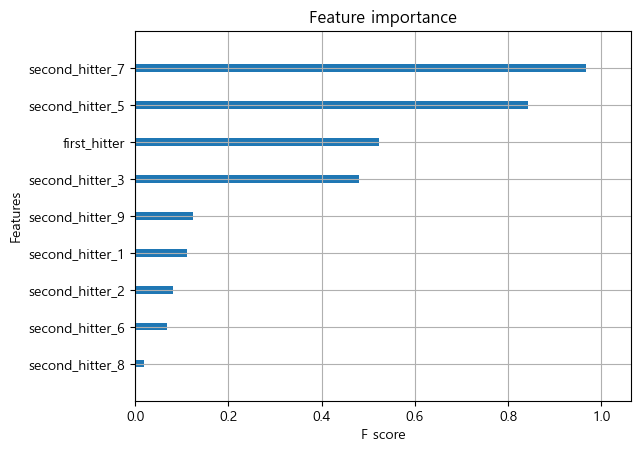

In [29]:
from xgboost import plot_importance

plot_importance(xgb, importance_type='gain', show_values=False) 
plt.show()

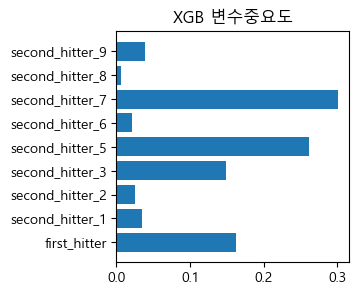

In [30]:
# model = xgb.XGBClassifier( random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

plt.figure(figsize=(3,3))
plt.barh(xgb.feature_names_in_, xgb.feature_importances_)
plt.title('XGB 변수중요도')
plt.show()

- 가장 큰 변수 중요도를 가지는 변수는 2번재 타자의 삼진제외 모든 아웃 변수이다.
- 그 다음으로 2번째 타자의 삼진, 세번째로는 첫번째 타자의 출루 순으로 변수 중요도가 높다.